In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1, L2
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL

%matplotlib inline

In [2]:
#models to explore, rbf neural network,  m-estimator based rbf, backprop nn, lstm rnn, look at support basis vector, nadaraya-watson, 
#gaussian process regressor

In [3]:
'''need to figure out when to start my analysis from, ideas could either be 1. at the start of volcker's tenure 2. after volcker got 
inflation under control in late 1982-1983 3. during greenspan's tenure 8/11/1987 '''

"need to figure out when to start my analysis from, ideas could either be 1. at the start of volcker's tenure 2. after volcker got \ninflation under control in late 1982-1983 3. during greenspan's tenure 8/11/1987 "

In [4]:
#need to select features to use 

In [5]:
#need to find some way to account for the zero lower bound

In [6]:
#need to check for stationary and autocorrelation

In [7]:
#features to check out, GDP, Inflation, yield curve, unemployment rate, industrial production, PCE (might be too 
#collinear with other indicators to be useful), retail sales, oil prices, Euro to dollar exchange rate, yen to dollar exchange rate, 
# m2, velocity of m2, real disposable personal income, imports, exports, recession status, nasdaq (maybe), price of gold 

In [8]:
#want to factor in the taylor rule in some way

In [9]:
oil_df = pd.read_csv('../data/Brent_oil.csv')
pce_df = pd.read_csv('../data/chained_pce.csv')
dis_inc_df = pd.read_csv('../data/dispos_income.csv')
export_df = pd.read_csv('../data/exports.csv')
ffr_1_df = pd.read_csv('../data/fed_funds_1.csv')
ffr_2_df = pd.read_csv('../data/fed_funds_2.csv')
gdp_gap_df = pd.read_csv('../data/gdp_gap.csv')
gdp_df = pd.read_csv('../data/GDP.csv')
import_df = pd.read_csv('../data/imports.csv')
ind_prod_df = pd.read_csv('../data/industrial_prod.csv')
m2_df = pd.read_csv('../data/M2.csv')
m2_velo_df = pd.read_csv('../data/M2_velo.csv')
nasdaq_df = pd.read_csv('../data/NASDAQ.csv')
pci_df = pd.read_csv('../data/PCI.csv')
pound_dollar_df = pd.read_csv('../data/pound_dollar.csv')
recession_df = pd.read_csv('../data/recession.csv')
unemployment_df = pd.read_csv('../data/unemployment.csv')
yen_dollar_df = pd.read_csv('../data/yen_to_dollar.csv')
net_exp_df = pd.read_csv('../data/NETEXP.csv')

In [10]:
oil_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9525 entries, 0 to 9524
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DATE          9525 non-null   object
 1   DCOILBRENTEU  9525 non-null   object
dtypes: object(2)
memory usage: 149.0+ KB


In [11]:
#daily no weekends
oil_df['DATE'] = pd.to_datetime(oil_df['DATE'])
oil_df.head()

,DATE,DCOILBRENTEU
0,1987-08-11,19.45
1,1987-08-12,19.50
2,1987-08-13,19.40
3,1987-08-14,19.25
4,1987-08-17,18.85


In [12]:
#quarterly
pce_df['DATE'] = pd.to_datetime(pce_df['DATE'])
pce_df.head()

,DATE,DPCCRV1Q225SBEA
0,1987-07-01,3.6
1,1987-10-01,4.1
2,1988-01-01,3.9
3,1988-04-01,4.9
4,1988-07-01,4.7


In [13]:
#monthly
dis_inc_df['DATE'] = pd.to_datetime(dis_inc_df['DATE'])
dis_inc_df.head()

,DATE,DSPIC96
0,1987-08-01,6574.0
1,1987-09-01,6575.3
2,1987-10-01,6619.6
3,1987-11-01,6648.1
4,1987-12-01,6711.5


In [14]:
#quarterly
export_df['DATE'] = pd.to_datetime(export_df['DATE'])
export_df.head()

,DATE,EXPGS
0,1987-07-01,371.854
1,1987-10-01,392.107
2,1988-01-01,418.727
3,1988-04-01,439.471
4,1988-07-01,453.586


In [15]:
#daily
ffr_1_df.head(8)

,DATE,DFEDTAR
0,1987-08-11,6.625
1,1987-08-12,6.625
2,1987-08-13,6.625
3,1987-08-14,6.625
4,1987-08-15,6.625
5,1987-08-16,6.625
6,1987-08-17,6.625
7,1987-08-18,6.625


In [16]:
#daily
ffr_2_df.head(8)
ffr_2_df = ffr_2_df.rename(columns={"Date": "Date", "DFEDTARU": "DFEDTAR"})
ffr_2_df.head()

,DATE,DFEDTAR
0,2008-12-16,0.25
1,2008-12-17,0.25
2,2008-12-18,0.25
3,2008-12-19,0.25
4,2008-12-20,0.25


In [17]:
#quarterly
gdp_gap_df['DATE'] = pd.to_datetime(gdp_gap_df['DATE'])
gdp_gap_df.head()

,DATE,GDPC1_GDPPOT
0,1987-07-01,-1.196214
1,1987-10-01,-0.293283
2,1988-01-01,-0.559415
3,1988-04-01,-0.037442
4,1988-07-01,-0.230370


In [18]:
#quarterly
gdp_df['DATE'] = pd.to_datetime(gdp_df['DATE'])
gdp_df.head()

,DATE,GDP
0,1987-07-01,4884.555
1,1987-10-01,5007.994
2,1988-01-01,5073.372
3,1988-04-01,5190.036
4,1988-07-01,5282.835


In [19]:
# quarterly 
import_df['DATE'] = pd.to_datetime(import_df['DATE'])
import_df.head()

,DATE,IMPGS
0,1987-07-01,517.318
1,1987-10-01,537.511
2,1988-01-01,542.714
3,1988-04-01,546.098
4,1988-07-01,552.849


In [20]:
#monthly 
ind_prod_df['DATE'] = pd.to_datetime(ind_prod_df['DATE'])
ind_prod_df.head()

,DATE,INDPRO
0,1987-08-01,58.6889
1,1987-09-01,58.9137
2,1987-10-01,59.7083
3,1987-11-01,60.0022
4,1987-12-01,60.3336


In [21]:
#weekly
m2_df['DATE'] = pd.to_datetime(m2_df['DATE'])
m2_df.head()

,DATE,WM2NS
0,1987-08-17,2792.5
1,1987-08-24,2780.3
2,1987-08-31,2778.2
3,1987-09-07,2801.9
4,1987-09-14,2807.3


In [22]:
#quarterly
m2_velo_df['DATE'] = pd.to_datetime(m2_velo_df['DATE'])
m2_velo_df.head()

,DATE,M2V
0,1987-07-01,1.751
1,1987-10-01,1.776
2,1988-01-01,1.768
3,1988-04-01,1.774
4,1988-07-01,1.790


In [23]:
#daily no weekends
nasdaq_df['DATE'] = pd.to_datetime(nasdaq_df['DATE'])
nasdaq_df.head()

,DATE,NASDAQCOM
0,1987-08-11,449.36
1,1987-08-12,449.23
2,1987-08-13,451.55
3,1987-08-14,451.61
4,1987-08-17,451.65


In [24]:
#monthly
pci_df['DATE'] = pd.to_datetime(pci_df['DATE'])
pci_df.head()

,DATE,CORESTICKM159SFRBATL
0,1987-08-01,4.293051
1,1987-09-01,4.305931
2,1987-10-01,4.356982
3,1987-11-01,4.329616
4,1987-12-01,4.291749


In [25]:
#daily no weekends
pound_dollar_df['DATE'] = pd.to_datetime(pound_dollar_df['DATE'])
pound_dollar_df.head()

,DATE,DEXUSUK
0,1987-08-11,1.5697
1,1987-08-12,1.5790
2,1987-08-13,1.5797
3,1987-08-14,1.5890
4,1987-08-17,1.5908


In [26]:
#monthly
recession_df['DATE'] = pd.to_datetime(recession_df['DATE'])
recession_df.head()

,DATE,RECPROUSM156N
0,1987-08-01,0.04
1,1987-09-01,0.00
2,1987-10-01,0.00
3,1987-11-01,0.02
4,1987-12-01,0.06


In [27]:
#monthly
unemployment_df['DATE'] = pd.to_datetime(unemployment_df['DATE'])
unemployment_df.head()

,DATE,UNRATE
0,1987-08-01,6.0
1,1987-09-01,5.9
2,1987-10-01,6.0
3,1987-11-01,5.8
4,1987-12-01,5.7


In [28]:
#daily no weekends
yen_dollar_df['DATE'] = pd.to_datetime(yen_dollar_df['DATE'])
yen_dollar_df.head()

,DATE,DEXJPUS
0,1987-08-11,151.77
1,1987-08-12,151.25
2,1987-08-13,151.45
3,1987-08-14,150.00
4,1987-08-17,149.92


In [29]:
net_exp_df['DATE'] = pd.to_datetime(net_exp_df['DATE'])
net_exp_df.head()

,DATE,NETEXP
0,1987-07-01,-145.464
1,1987-10-01,-145.405
2,1988-01-01,-123.987
3,1988-04-01,-106.627
4,1988-07-01,-99.263


In [30]:
ffr_df = pd.concat([ffr_1_df, ffr_2_df], ignore_index=True)
ffr_df.head()

,DATE,DFEDTAR
0,1987-08-11,6.625
1,1987-08-12,6.625
2,1987-08-13,6.625
3,1987-08-14,6.625
4,1987-08-15,6.625


In [31]:
ffr_df.info()
ffr_df = ffr_df.rename(columns={"DATE": "DATE", "DFEDTAR": "FFTR"})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13344 entries, 0 to 13343
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     13344 non-null  object 
 1   DFEDTAR  13344 non-null  float64
dtypes: float64(1), object(1)
memory usage: 208.6+ KB


In [32]:
#need to change this to datetime object after joining dataframes
type(ffr_df['DATE'][1])

str

In [33]:
ffr_df['DATE'] = pd.to_datetime(ffr_df['DATE'])

In [34]:
type(unemployment_df['DATE'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [35]:
test_merge_df = ffr_df.merge(unemployment_df, left_on='DATE', right_on='DATE')
test_merge_df.head()

,DATE,FFTR,UNRATE
0,1987-09-01,6.7500,5.9
1,1987-10-01,7.3125,6.0
2,1987-11-01,7.3125,5.8
3,1987-12-01,6.8125,5.7
4,1988-01-01,6.8125,5.7


In [36]:
test_merge_df = pd.merge_ordered(ffr_df, unemployment_df, fill_method="none", left_by="DATE")
test_merge_df.head(31)

,DATE,FFTR,UNRATE
0,1987-08-11,6.625,NaN
1,1987-08-12,6.625,NaN
2,1987-08-13,6.625,NaN
3,1987-08-14,6.625,NaN
4,1987-08-15,6.625,NaN
5,1987-08-16,6.625,NaN
6,1987-08-17,6.625,NaN
7,1987-08-18,6.625,NaN
8,1987-08-19,6.625,NaN
9,1987-08-20,6.625,NaN


In [37]:
test_merge_df['UNRATE'] = test_merge_df['UNRATE'].interpolate(method='linear', limit_direction= 'both', axis=0)
test_merge_df.head(31)

,DATE,FFTR,UNRATE
0,1987-08-11,6.625,5.900000
1,1987-08-12,6.625,5.900000
2,1987-08-13,6.625,5.900000
3,1987-08-14,6.625,5.900000
4,1987-08-15,6.625,5.900000
5,1987-08-16,6.625,5.900000
6,1987-08-17,6.625,5.900000
7,1987-08-18,6.625,5.900000
8,1987-08-19,6.625,5.900000
9,1987-08-20,6.625,5.900000


In [38]:
#that shouldnt be a string, changing it
type(oil_df['DCOILBRENTEU'][1])

str

In [39]:
oil_df = oil_df.rename(columns={"DATE": "DATE", "DCOILBRENTEU": "Oil"})
merge_df = pd.merge_ordered(test_merge_df, oil_df, fill_method="none", left_by="DATE")
merge_df['Oil'] = merge_df['Oil'].replace('.', np.nan)
merge_df['Oil'] = merge_df['Oil'].astype(float)
merge_df['Oil'] = merge_df['Oil'].interpolate(method='linear',  axis=0)
merge_df.head(31)

,DATE,FFTR,UNRATE,Oil
0,1987-08-11,6.625,5.900000,19.450000
1,1987-08-12,6.625,5.900000,19.500000
2,1987-08-13,6.625,5.900000,19.400000
3,1987-08-14,6.625,5.900000,19.250000
4,1987-08-15,6.625,5.900000,19.116667
5,1987-08-16,6.625,5.900000,18.983333
6,1987-08-17,6.625,5.900000,18.850000
7,1987-08-18,6.625,5.900000,18.750000
8,1987-08-19,6.625,5.900000,18.500000
9,1987-08-20,6.625,5.900000,18.300000


In [40]:
pce_df = pce_df.rename(columns={"DATE": "DATE", "DPCCRV1Q225SBEA": "PCE"})
merge_df = pd.merge_ordered(merge_df, pce_df, fill_method="ffill")
merge_df.head()

,DATE,FFTR,UNRATE,Oil,PCE
0,1987-07-01,NaN,NaN,NaN,3.6
1,1987-08-11,6.625,5.9,19.45,3.6
2,1987-08-12,6.625,5.9,19.50,3.6
3,1987-08-13,6.625,5.9,19.40,3.6
4,1987-08-14,6.625,5.9,19.25,3.6


In [41]:
type(merge_df['PCE'][1])

numpy.float64

In [42]:
dis_inc_df = dis_inc_df.rename(columns={"DATE": "DATE", "DSPIC96": "DispInc"})
merge_df = pd.merge_ordered(merge_df, dis_inc_df, fill_method="ffill")

In [43]:
gdp_gap_df = gdp_gap_df.rename(columns={"DATE": "DATE", "GDPC1_GDPPOT": "gdp_gap"})
merge_df = pd.merge_ordered(merge_df, gdp_gap_df, fill_method="ffill")

In [44]:
merge_df = pd.merge_ordered(merge_df, gdp_df, fill_method="ffill")

In [45]:
test_bug_df = pd.merge_ordered(export_df, import_df, fill_method="ffill", left_by="DATE")

In [46]:
merge_df = pd.merge_ordered(merge_df, test_bug_df, fill_method="ffill")

In [47]:
ind_prod_df = ind_prod_df.rename(columns={"DATE": "DATE", "INDPRO": "ind_prod"})
merge_df = pd.merge_ordered(merge_df, ind_prod_df, fill_method="ffill")

In [48]:
ind_prod_df = ind_prod_df.rename(columns={"DATE": "DATE", "INDPRO": "ind_prod"})
merge_df = pd.merge_ordered(merge_df, ind_prod_df, fill_method="ffill")

In [49]:
m2_df = m2_df.rename(columns={"DATE": "DATE", "WM2NS": "m2"})
merge_df = pd.merge_ordered(merge_df, m2_df, fill_method="none")
merge_df['m2'] = merge_df['m2'].interpolate(method='linear', limit_direction= 'both', axis=0)
merge_df.head()

,DATE,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,m2
0,1987-07-01,NaN,NaN,NaN,3.6,NaN,-1.196214,4884.555,371.854,517.318,NaN,2792.5
1,1987-08-01,NaN,NaN,NaN,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5
2,1987-08-11,6.625,5.9,19.45,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5
3,1987-08-12,6.625,5.9,19.50,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5
4,1987-08-13,6.625,5.9,19.40,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5


In [50]:
m2_velo_df = ind_prod_df.rename(columns={"DATE": "DATE", "M2V": "m2_velo"})
merge_df = pd.merge_ordered(merge_df, m2_velo_df, fill_method="forward")

In [51]:
nasdaq_df = nasdaq_df.rename(columns={"DATE": "DATE", "NASDAQCOM": "nasdaq"})
merge_df = pd.merge_ordered(merge_df, nasdaq_df, fill_method="none")

In [52]:
pci_df = pci_df.rename(columns={"DATE": "DATE", "CORESTICKM159SFRBATL": "pci"})
merge_df = pd.merge_ordered(merge_df, pci_df, fill_method="ffill")

In [53]:
pound_dollar_df = pound_dollar_df.rename(columns={"DATE": "DATE", "DEXUSUK": "gbp_dollar"})
merge_df = pd.merge_ordered(merge_df, pound_dollar_df, fill_method="none")

In [54]:
recession_df = recession_df.rename(columns={"DATE": "DATE", "RECPROUSM156N": "pct_recession"})
merge_df = pd.merge_ordered(merge_df, recession_df, fill_method="ffill")

In [55]:
yen_dollar_df = yen_dollar_df.rename(columns={"DATE": "DATE", "DEXJPUS": "yen_dollar"})
merge_df = pd.merge_ordered(merge_df, yen_dollar_df, fill_method="none")

In [56]:
merge_df = merge_df.iloc[2:]

In [57]:
merge_df = merge_df.set_index('DATE')

In [58]:
merge_df['nasdaq'] = merge_df['nasdaq'].replace('.', np.nan)
merge_df['nasdaq'] = merge_df['nasdaq'].astype(float)
merge_df['nasdaq'] = merge_df['nasdaq'].interpolate(method='linear', limit_direction= 'forward', axis=0)
merge_df['gbp_dollar'] = merge_df['gbp_dollar'].replace('.', np.nan)
merge_df['gbp_dollar'] = merge_df['gbp_dollar'].astype(float)
merge_df['gbp_dollar'] = merge_df['gbp_dollar'].interpolate(method='linear', limit_direction= 'forward', axis=0)
merge_df['yen_dollar'] = merge_df['yen_dollar'].replace('.', np.nan)
merge_df['yen_dollar'] = merge_df['yen_dollar'].astype(float)
merge_df['yen_dollar'] = merge_df['yen_dollar'].interpolate(method='linear', limit_direction= 'forward', axis=0)
#merge_df['nasdaq'].fillna()

In [59]:
type(merge_df['nasdaq'][1])

numpy.float64

In [60]:
merge_df.isna().sum()

FFTR             0
UNRATE           0
Oil              0
PCE              0
DispInc          0
gdp_gap          0
GDP              0
EXPGS            0
IMPGS            0
ind_prod         0
m2               0
nasdaq           0
pci              0
gbp_dollar       0
pct_recession    0
yen_dollar       0
dtype: int64

In [61]:
merge_df['nasdaq'].head(55)

DATE
1987-08-11    449.360000
1987-08-12    449.230000
1987-08-13    451.550000
1987-08-14    451.610000
1987-08-15    451.623333
1987-08-16    451.636667
1987-08-17    451.650000
1987-08-18    446.760000
1987-08-19    447.950000
1987-08-20    452.750000
1987-08-21    455.200000
1987-08-22    454.733333
1987-08-23    454.266667
1987-08-24    453.800000
1987-08-25    455.100000
1987-08-26    455.260000
1987-08-27    454.790000
1987-08-28    453.290000
1987-08-29    453.850000
1987-08-30    454.410000
1987-08-31    454.970000
1987-09-01    452.500000
1987-09-02    448.930000
1987-09-03    448.360000
1987-09-04    446.480000
1987-09-05    444.260000
1987-09-06    442.040000
1987-09-07    439.820000
1987-09-08    437.600000
1987-09-09    439.190000
1987-09-10    443.480000
1987-09-11    446.170000
1987-09-12    445.943333
1987-09-13    445.716667
1987-09-14    445.490000
1987-09-15    441.940000
1987-09-16    440.850000
1987-09-17    440.750000
1987-09-18    440.860000
1987-09-19    439.24

In [62]:
# Import required libraries
from statsmodels.tsa.stattools import adfuller, kpss

# Perform ADF test
result = adfuller(merge_df['FFTR'])
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# Perform KPSS test
result = kpss(merge_df['FFTR'])
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))


ADF test:	p-value: 0.544
KPSS test:	p-value: 0.010


/var/folders/wq/4pbqhwns4pg_cmgzb1t39xdr0000gn/T/ipykernel_76405/2845122523.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(merge_df['FFTR'])


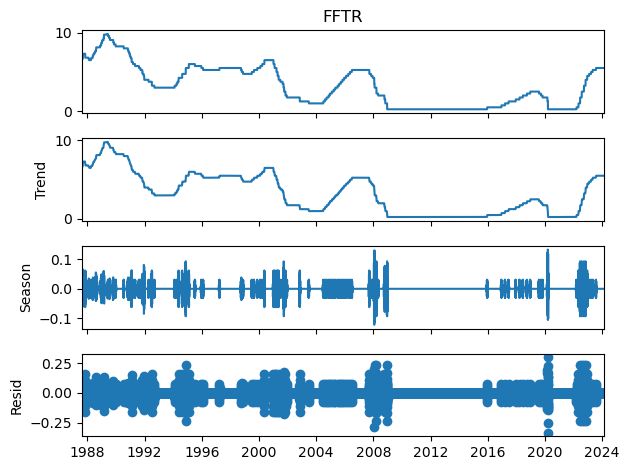

In [76]:
stl = STL(merge_df['FFTR'], seasonal=)
res = stl.fit()
fig = res.plot()

In [ ]:
merge_df['Time'] = np.arange(len(merge_df.index))
merge_df_30 = merge_df
merge_df_60 = merge_df
merge_df_90 = merge_df
merge_df.head()

In [ ]:
merge_df_30['fftr_lag'] = merge_df['FFTR'].shift(30)
merge_df_60['fftr_lag'] = merge_df['FFTR'].shift(60)
merge_df_90['fftr_lag'] = merge_df['FFTR'].shift(90)
merge_df_30 = merge_df_30.dropna()
merge_df_60 = merge_df_60.dropna()
merge_df_90 = merge_df_90.dropna()

In [ ]:
merge_df.head()

In [ ]:
X_30 = merge_df_30.drop(columns = 'fftr_lag')
X_60 = merge_df_60.drop(columns = 'fftr_lag')
X_90 = merge_df_90.drop(columns = 'fftr_lag')
y_30 = merge_df_30['fftr_lag']
y_60 = merge_df_60['fftr_lag']
y_90 = merge_df_90['fftr_lag']
X_train_30, X_test_30, y_train_30, y_test_30 = TimeSeriesSplit(X_30, y_30, test_size = .25, random_state = 42)
X_train_60, X_test_60, y_train_60, y_test_60 = TimeSeriesSplit(X_60, y_60, test_size = .25, random_state = 42)
X_train_90, X_test_90, y_train_90, y_test_90 = TimeSeriesSplit(X_90, y_90, test_size = .25, random_state = 42)

In [ ]:
merge_df.describe()

In [ ]:
steps = [('scaler', MinMaxScaler()),
         ('linreg', LinearRegression())]
params = {'linreg__fit_intercept': [False]}
lin_pipe = ImPipeline(steps)
linreg_cv = GridSearchCV(estimator = lin_pipe, param_grid = params, cv = 5)

In [ ]:
linreg_cv.fit(X_train_30, y_train_30)

In [ ]:
linreg_cv.best_score_

In [ ]:
linreg_cv.fit(X_train_60, y_train_60)
linreg_cv.best_score_

In [ ]:
merge_df_30.head()

In [ ]:
X_train_30.head()

In [ ]:
merge_df.plot.line(y='FFTR')

In [77]:
merge_df.head()

,FFTR,UNRATE,Oil,PCE,DispInc,gdp_gap,GDP,EXPGS,IMPGS,ind_prod,m2,nasdaq,pci,gbp_dollar,pct_recession,yen_dollar
DATE,,,,,,,,,,,,,,,,
1987-08-11,6.625,5.9,19.450000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,449.360000,4.293051,1.5697,0.04,151.770000
1987-08-12,6.625,5.9,19.500000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,449.230000,4.293051,1.5790,0.04,151.250000
1987-08-13,6.625,5.9,19.400000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,451.550000,4.293051,1.5797,0.04,151.450000
1987-08-14,6.625,5.9,19.250000,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,451.610000,4.293051,1.5890,0.04,150.000000
1987-08-15,6.625,5.9,19.116667,3.6,6574.0,-1.196214,4884.555,371.854,517.318,58.6889,2792.5,451.623333,4.293051,1.5896,0.04,149.973333
